# Online Advertisement Campaign Analysis

In [31]:
# packages
import pandas as pd
import os
from dotenv import load_dotenv
from google.cloud import bigquery
from scipy.stats import shapiro # normality test
from scipy.stats import ttest_ind # normal dist
from scipy.stats import mannwhitneyu # non-normal dist
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

### Data Wrangling

Within our query, we perform the following preprocessing steps:
1. Restructure our data by unioning two tables
2. Clean up the date data type
3. Handle nulls with interpolation
4. Enrich the dataset with calculations

In [32]:
# retreive data from bigquery

load_dotenv()
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Initialize the BigQuery Client
client = bigquery.Client()

# BQ query
sql_query = """
        WITH 
            campaign_union AS (
                -- combine our control and test data sets
                SELECT 
                    * 
                FROM `crudek-data.practice_data.campaign_cntrl`
                UNION ALL
                SELECT 
                    * 
                FROM`crudek-data.practice_data.campaign_test`
            ),
            campaign_clean AS (
                SELECT 
                    campaign_name,
                    -- format as a date
                    PARSE_DATE('%d.%m.%Y', date) AS date,
                    spend_usd,
                    -- handle missing data with linear interpolation (could also remove, impute, etc.)
                    COALESCE(impressions, (LAG(impressions) OVER (ORDER BY campaign_name, date) + LEAD(impressions) OVER (ORDER BY campaign_name, date)) / 2) AS impressions,
                    COALESCE(reach, (LAG(reach) OVER (ORDER BY campaign_name, date) + LEAD(reach) OVER (ORDER BY campaign_name, date)) / 2) AS reach,
                    COALESCE(website_clicks, (LAG(website_clicks) OVER (ORDER BY campaign_name, date) + LEAD(website_clicks) OVER (ORDER BY campaign_name, date)) / 2) AS website_clicks,
                    COALESCE(searches, (LAG(searches) OVER (ORDER BY campaign_name, date) + LEAD(searches) OVER (ORDER BY campaign_name, date)) / 2) AS searches,
                    COALESCE(content_views, (LAG(content_views) OVER (ORDER BY campaign_name, date) + LEAD(content_views) OVER (ORDER BY campaign_name, date)) / 2) AS content_views,
                    COALESCE(add_to_cart, (LAG(add_to_cart) OVER (ORDER BY campaign_name, date) + LEAD(add_to_cart) OVER (ORDER BY campaign_name, date)) / 2) AS add_to_cart,
                    COALESCE(purchases, (LAG(purchases) OVER (ORDER BY campaign_name, date) + LEAD(purchases) OVER (ORDER BY campaign_name, date)) / 2) AS purchases
                FROM campaign_union
                ORDER BY campaign_name, date
            ),
            campaign_calcs AS (
                SELECT
                    campaign_name,
                    date,
                    (purchases / website_clicks) AS conversion_rate,
                    (website_clicks / impressions) AS click_through_rate, -- CTR
                    (spend_usd / website_clicks) AS cost_per_click, -- CPC
                FROM campaign_clean
            )
        SELECT *
        FROM campaign_calcs
        ORDER BY campaign_name, date
"""

query_job = client.query(
    sql_query)

# retreive and convert the result to a Pandas DataFrame
df = query_job.to_dataframe()

# Features

##### [Conversion Rate](https://support.google.com/google-ads/answer/2684489?hl=en#:~:text=The%20average%20number%20of%20conversions,during%20the%20same%20time%20period.)
**Definition:** the number of users who made a purchase after clicking our ad (assuming our desired action is a user purchasing)  \
**Importance:** did the ad perform well?


##### [Click Through Rate (CTR)](https://support.google.com/google-ads/answer/2615875?hl=en#:~:text=Clickthrough%20rate%20%20can%20be,your%20CTR%20would%20be%205%25.)
**Definition:** how many users clicked on your ad after seeing it \
**Importance:** did the ad capture users attention?


##### [Cost Per Click (CPC)](https://support.google.com/google-ads/answer/116495?hl=en)
**Definition:** how much we, the advertiser, paid for each ad click \
**Importance:** was our ad cost effective?

In [33]:
# quick look at our data
print(df.head())
print(df.dtypes)

      campaign_name        date  conversion_rate  click_through_rate  \
0  Control Campaign  2019-08-01         0.088084            0.084835   
1  Control Campaign  2019-08-02         0.063009            0.067003   
2  Control Campaign  2019-08-03         0.057160            0.049411   
3  Control Campaign  2019-08-04         0.110930            0.042057   
4  Control Campaign  2019-08-05         0.155646            0.038982   

   cost_per_click  
0        0.324971  
1        0.216646  
2        0.360018  
3        0.632953  
4        0.517412  
campaign_name          object
date                   dbdate
conversion_rate       float64
click_through_rate    float64
cost_per_click        float64
dtype: object


# Analysis

### Viz

Before getting in to hypothesis testing, we can visualize our data. This can help us generate our own hypotheses based on what we observe and inspect for outliers... among other 
things

In [34]:
# initial prep 

# features in play
metrics = df.select_dtypes(include=['number']).columns.tolist() # may not always be this way (all numeric data types) but for this it works

# split data by our two campaigns
test_group = df[df['campaign_name'] == 'Test Campaign']
control_group = df[df['campaign_name'] == 'Control Campaign']

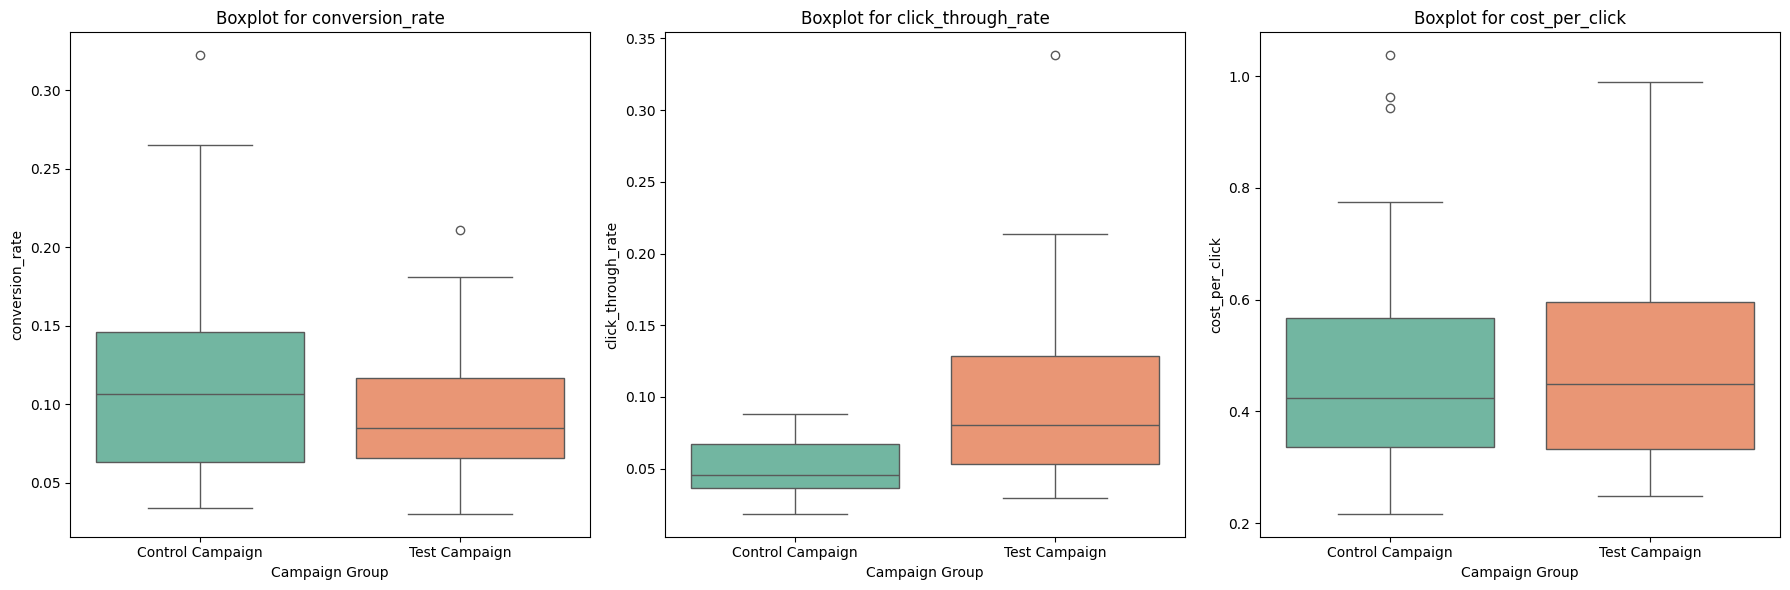

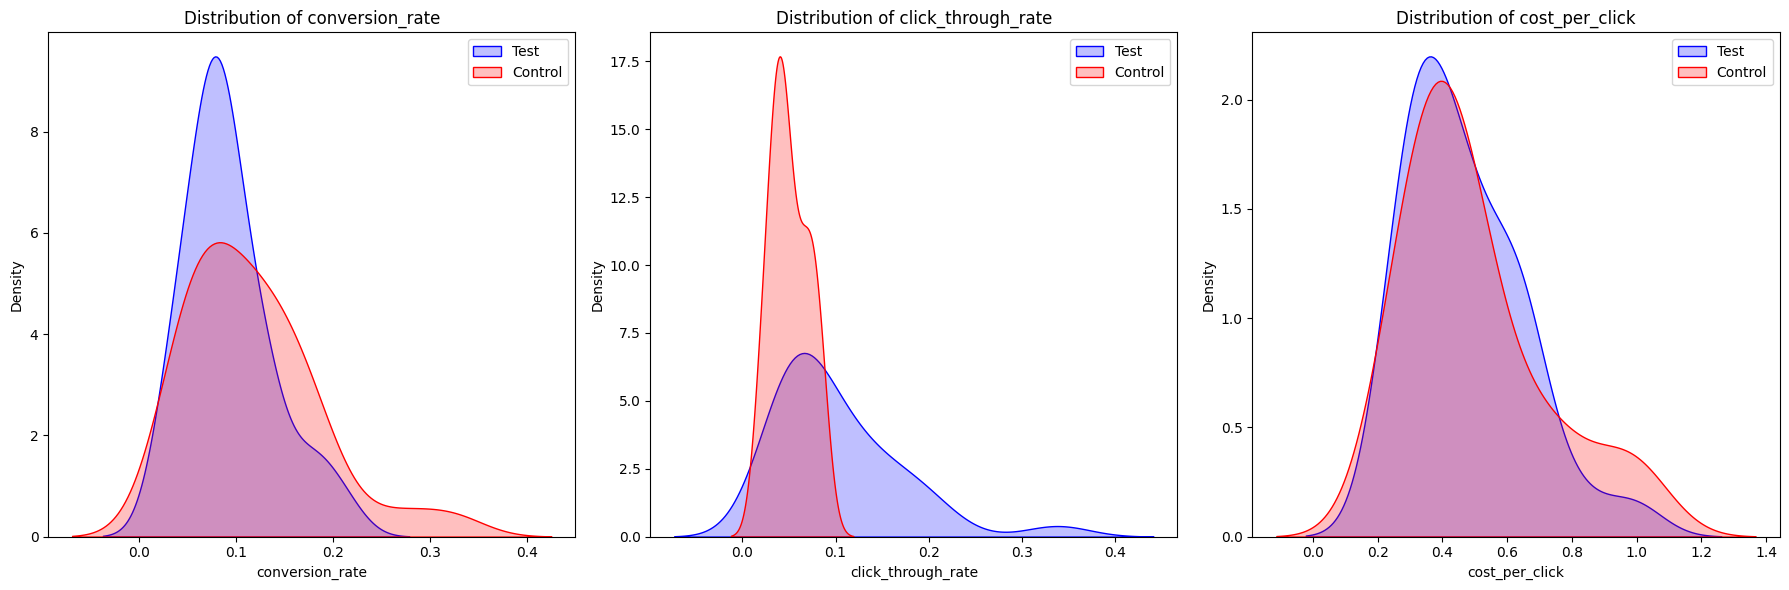

In [35]:
warnings.filterwarnings('ignore') # Suppress all warnings

# Create a 1x3 layout for three metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.ravel()  # Flatten the array of axes for easy iteration

# Loop through the metrics and plot boxplots
for i, metric in enumerate(metrics):
    sns.boxplot(x='campaign_name', y=metric, data=df, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Boxplot for {metric}')
    axes[i].set_xlabel('Campaign Group')
    axes[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

# Create another 1x3 layout for the KDE plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.ravel()

# Loop through the metrics and plot KDE plots
for i, metric in enumerate(metrics):
    sns.kdeplot(test_group[metric], shade=True, label='Test', ax=axes[i], color="b")
    sns.kdeplot(control_group[metric], shade=True, label='Control', ax=axes[i], color="r")
    axes[i].set_title(f'Distribution of {metric}')
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

After visualizing the data, our initial guesses could be:
- there may be a difference in Conversion Rate between the two campaigns
- there likely is a difference in CTR between the two campaigns
- there probably is no difference in CPC between the two campaigns

### Hypothesis Testing

We can test for normality and then do the following:
1. T-test: if our data is normally distributed
2. Mann-Whitney U test: if we have non-normal distribution

In [36]:
# Shapiro-Wilk test for normality
    # Null: The data is drawn from a normal distribution (i.e., the data is normally distributed).
    # Alt: The data is not drawn from a normal distribution (i.e., the data is not normally distributed).
        # If the p-value is greater than 0.05 (or your chosen significance level), you fail to reject the null hypothesis, meaning the data is likely normally distributed.
        # If the p-value is less than or equal to 0.05, you reject the null hypothesis, meaning the data is likely not normally distributed.

# fields to test
metrics = df.select_dtypes(include=['number']).columns.tolist()

# loop over each metric and perform the Shapiro-Wilk normality test
for metric in metrics:
    test_stat, p_value = shapiro(df[metric])
    print(f'Normality test for {metric}:')
    print(f'  Test Statistic = {test_stat:.4f}, p-value = {p_value:.4f}')
    if p_value > 0.05:
        print(f'  {metric} is likely normally distributed (fail to reject H0)\n')
    else:
        print(f'  {metric} is not normally distributed (reject H0)\n')

Normality test for conversion_rate:
  Test Statistic = 0.8973, p-value = 0.0001
  conversion_rate is not normally distributed (reject H0)

Normality test for click_through_rate:
  Test Statistic = 0.7675, p-value = 0.0000
  click_through_rate is not normally distributed (reject H0)

Normality test for cost_per_click:
  Test Statistic = 0.8981, p-value = 0.0001
  cost_per_click is not normally distributed (reject H0)



We can see that all three metrics had a low p-value, meaning our data is not normally distributed, resulting in a rejection of the null. Therefore, we will proceed with the Mann-Whitney U test for all three features. Below we will run our hypothesis tests.
- Null: The distribution of the two campaigns (Contorl & Test) are the same, meaning there is no significant difference in their distributions.
- Alternative: The distribution of the two campaigns are different, meaning there is a significant difference between the two groups.

In [37]:
# loop over each metric and perform the Mann-Whitney U test
for metric in metrics:
    test_stat, p_value = mannwhitneyu(test_group[metric], control_group[metric], alternative='two-sided')
    print(f'Mann-Whitney U test for {metric}:')
    print(f'  Test Statistic = {test_stat:.4f}, p-value = {p_value:.4f}')
    if p_value < 0.05:
        print(f'  Significant difference between Test and Control for {metric} (reject H0)\n')
    else:
        print(f'  No significant difference between Test and Control for {metric} (fail to reject H0)\n')


Mann-Whitney U test for conversion_rate:
  Test Statistic = 370.0000, p-value = 0.2398
  No significant difference between Test and Control for conversion_rate (fail to reject H0)

Mann-Whitney U test for click_through_rate:
  Test Statistic = 705.0000, p-value = 0.0002
  Significant difference between Test and Control for click_through_rate (reject H0)

Mann-Whitney U test for cost_per_click:
  Test Statistic = 430.0000, p-value = 0.7731
  No significant difference between Test and Control for cost_per_click (fail to reject H0)



# Conclusion

**Click Through Rate (CTR)** for the Test campaign is statisitcally different (unlikely to have occured by random chance) from that of the Control campaign. This suggests that the ad for the Test campaign may have been more engaging and/or appealing than that of the Control campaign. Next steps might be to ask why this didn't translate to a statisitically different conversion rates or CPC's. With this data, ROI was impossible to calculate. However, ROI would be another way to get a fuller picture of campaign effectiveness and a great way to get the ear of the CFO.